# Chapter 6 Lab 4

## Goal
In this lab, we will walk through applying Hierarchical Clustering (HC) for clustering players in the DoTalicious data set. There are functions available available in the scipy library.

## Brief Refresher
Hierarchical clustering does not produce a single clustering result like the partitional methods explored in previous labs. The result is a tree, called a dendrogram, representing the data grouped together based on similarity. By picking a specific similarity value, the user can deduce one single clustering result from the resulting tree.

Also, as opposed to the K-Means clustering types, we do not need to pre-specify the number of clusters; that is, we do not need to pre-commit to an choice of K.

## Preparation

First, import packages.

In [303]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Step 1: Data Pre-processing

Let's read in the data and take a quick look at it.

In [214]:
dota_df1 = pd.read_csv('DoTalicious_cleaned1000players.csv')
#dota_df1.set_index('PlayerID', inplace=True)
dota_df1.drop(['PlayerID'], axis=1, inplace=True)
dota_df1.head()

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,SkillLevel,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
0,447,248,6,6,1111.360,1,2271,0.12,1889,4201,38736,3058,3456,355,151,1116780
1,66,39,0,0,989.882,1,373,0.13,450,745,4484,518,455,49,23,169800
2,3,0,0,0,1000.000,0,11,0.11,28,18,186,10,7,0,0,6180
3,100,59,5,1,1228.460,1,1079,0.26,448,934,13943,1885,1417,132,36,250200
4,1,1,0,0,1020.000,0,9,0.28,2,10,38,8,3,0,0,1944


In [215]:
dota_df1.describe()

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed
count,868.000000,868.00000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000
mean,92.237327,50.31106,1.648618,0.710829,1014.823758,607.959677,0.131647,544.466590,950.667051,7628.033410,676.846774,1258.349078,70.705069,29.706221
std,205.479733,115.74130,3.237936,1.808100,119.886844,1502.029784,0.065943,1203.587862,2229.756349,19791.299384,2028.735323,2968.096246,175.784813,74.624814
min,0.000000,0.00000,0.000000,0.000000,626.837000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.00000,0.000000,0.000000,962.085500,11.000000,0.090000,17.000000,18.000000,159.500000,12.000000,16.000000,1.000000,0.000000
50%,15.000000,7.00000,0.000000,0.000000,996.734000,74.000000,0.130000,92.500000,124.000000,979.000000,76.000000,145.500000,7.000000,3.000000
75%,90.000000,47.25000,2.000000,1.000000,1046.702500,512.750000,0.170000,554.000000,863.500000,6723.000000,540.750000,1126.750000,61.500000,26.000000
max,3156.000000,1764.00000,40.000000,18.000000,2010.240000,23742.000000,0.420000,16988.000000,34390.000000,372360.000000,43910.000000,42900.000000,2601.000000,1141.000000


In [216]:
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GamesPlayed       868 non-null    int64  
 1   GamesWon          868 non-null    int64  
 2   GamesLeft         868 non-null    int64  
 3   Ditches           868 non-null    int64  
 4   Points            868 non-null    float64
 5   SkillLevel        868 non-null    object 
 6   Kills             868 non-null    int64  
 7   KillsPerMin       868 non-null    float64
 8    Deaths           868 non-null    int64  
 9   Assists           868 non-null    int64  
 10  CreepsKilled      868 non-null    int64  
 11  CreepsDenied      868 non-null    int64  
 12   NeutralsKilled   868 non-null    int64  
 13   TowersDestroyed  868 non-null    int64  
 14   RaxsDestroyed    868 non-null    int64  
 15   TotalTime        868 non-null    object 
dtypes: float64(2), int64(12), object(2)
memory u

Notice that we will need to change some data types.

In [217]:
dota_df1[' TotalTime'] = pd.to_numeric(dota_df1[' TotalTime'], errors="coerce")

We'll make a quick fix to an odd value in SkillLevel too. I've randomly chosen to make it a 1.

In [218]:
dota_df1.loc[dota_df1['SkillLevel'] ==' SkillLevelNull', 'SkillLevel'] = '1'

Lastly, let's work on the SkillLevel column!

In [219]:
dota_df1['SkillLevel'] = pd.Series(dota_df1['SkillLevel'].astype('category'))
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   GamesPlayed       868 non-null    int64   
 1   GamesWon          868 non-null    int64   
 2   GamesLeft         868 non-null    int64   
 3   Ditches           868 non-null    int64   
 4   Points            868 non-null    float64 
 5   SkillLevel        868 non-null    category
 6   Kills             868 non-null    int64   
 7   KillsPerMin       868 non-null    float64 
 8    Deaths           868 non-null    int64   
 9   Assists           868 non-null    int64   
 10  CreepsKilled      868 non-null    int64   
 11  CreepsDenied      868 non-null    int64   
 12   NeutralsKilled   868 non-null    int64   
 13   TowersDestroyed  868 non-null    int64   
 14   RaxsDestroyed    868 non-null    int64   
 15   TotalTime        867 non-null    float64 
dtypes: category(1), float64(3)

In [220]:
dota_df1['SkillLevel'] = dota_df1['SkillLevel'].cat.rename_categories({'0':'N', '1':'B', '2':'I', '3':'A'})
dota_df1.head()

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,SkillLevel,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
0,447,248,6,6,1111.360,B,2271,0.12,1889,4201,38736,3058,3456,355,151,1116780.0
1,66,39,0,0,989.882,B,373,0.13,450,745,4484,518,455,49,23,169800.0
2,3,0,0,0,1000.000,N,11,0.11,28,18,186,10,7,0,0,6180.0
3,100,59,5,1,1228.460,B,1079,0.26,448,934,13943,1885,1417,132,36,250200.0
4,1,1,0,0,1020.000,N,9,0.28,2,10,38,8,3,0,0,1944.0


Next, let's check for null values and remove those.

In [221]:
dota_df1.isna().sum().sum()

1

In [222]:
dota_df1[dota_df1.isnull().any(axis=1)]

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,SkillLevel,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
517,0,0,0,0,1000.0,N,0,0.0,0,0,0,0,0,0,0,NaN


In [223]:
dota_df1.drop([517], inplace=True)

In [224]:
dota_df1.isna().sum().sum()

0

Also, since SkillLevel is categorical, sklearn dbscan cannot use it. We will copy it into a dataframe of its own (which will come in handy for us at the end of the lab).

In [225]:
dota_level = pd.DataFrame(dota_df1['SkillLevel']) # We're going to use this at the end of the lab!
dota_df1.drop(['SkillLevel'], axis=1, inplace=True)
dota_df1.head()

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
0,447,248,6,6,1111.360,2271,0.12,1889,4201,38736,3058,3456,355,151,1116780.0
1,66,39,0,0,989.882,373,0.13,450,745,4484,518,455,49,23,169800.0
2,3,0,0,0,1000.000,11,0.11,28,18,186,10,7,0,0,6180.0
3,100,59,5,1,1228.460,1079,0.26,448,934,13943,1885,1417,132,36,250200.0
4,1,1,0,0,1020.000,9,0.28,2,10,38,8,3,0,0,1944.0


In [226]:
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 867 entries, 0 to 867
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GamesPlayed       867 non-null    int64  
 1   GamesWon          867 non-null    int64  
 2   GamesLeft         867 non-null    int64  
 3   Ditches           867 non-null    int64  
 4   Points            867 non-null    float64
 5   Kills             867 non-null    int64  
 6   KillsPerMin       867 non-null    float64
 7    Deaths           867 non-null    int64  
 8   Assists           867 non-null    int64  
 9   CreepsKilled      867 non-null    int64  
 10  CreepsDenied      867 non-null    int64  
 11   NeutralsKilled   867 non-null    int64  
 12   TowersDestroyed  867 non-null    int64  
 13   RaxsDestroyed    867 non-null    int64  
 14   TotalTime        867 non-null    float64
dtypes: float64(3), int64(12)
memory usage: 108.4 KB


Now that we've got some nice data, let's scale it. 

Also, let's get rid of some of the leading spaces in the columns names.

In [227]:
scaler = StandardScaler()
dota_df2 = pd.DataFrame(scaler.fit_transform(dota_df1), columns = dota_df1.columns)

dota_df2 = dota_df2.rename(columns=lambda x: x.strip())
dota_df2

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
0,1.726192,1.707709,1.343489,2.925072,0.805092,1.106833,-0.179345,1.116715,1.457369,1.571490,1.173404,0.740012,1.616977,1.625071,1.871061
1,-0.128221,-0.098239,-0.509820,-0.393625,-0.208189,-0.156910,-0.027349,-0.079019,-0.092739,-0.159318,-0.078688,-0.271179,-0.123951,-0.090333,-0.123286
2,-0.434856,-0.435234,-0.509820,-0.393625,-0.123792,-0.397940,-0.331341,-0.429678,-0.418818,-0.376502,-0.329107,-0.422133,-0.402727,-0.398570,-0.467871
3,0.037265,0.074579,1.034604,0.159491,1.781855,0.313165,1.948600,-0.080680,-0.007967,0.318661,0.595174,0.052969,0.348262,0.083887,0.046037
4,-0.444591,-0.426593,-0.509820,-0.393625,0.043034,-0.399271,2.252592,-0.451283,-0.422406,-0.383981,-0.330093,-0.423481,-0.402727,-0.398570,-0.476792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,-0.444591,-0.435234,-0.509820,-0.393625,-0.123792,-0.401935,0.428639,-0.447959,-0.423303,-0.382111,-0.330586,-0.419100,-0.402727,-0.398570,-0.476899
863,-0.332644,-0.357466,-0.200936,-0.393625,-0.753041,-0.342010,-0.635333,-0.300882,-0.347054,-0.321928,-0.271432,-0.294091,-0.345834,-0.371767,-0.350987
864,-0.444591,-0.435234,-0.509820,-0.393625,-0.123792,-0.404598,-1.395313,-0.448790,-0.426443,-0.384992,-0.333543,-0.424491,-0.402727,-0.398570,-0.477371
865,0.061601,0.221474,-0.200936,0.159491,1.076935,0.558856,3.164568,0.107114,0.089363,0.153523,0.125393,0.030730,0.371019,0.271510,0.056272


## Step 2: Apply the hierarchical clustering methods

Below we will implement sci-kit AgglomerativeClustering. If you do not specify 'precomputed' as the metric parameter, the tree will be built from the features rather than a distance matrix. If you have a distance matrix, then set the metric parameter to 'precomputed'.

Sci-kit has not yet incorporated a divisive clustering algorithm with some users citing it's lack of use in the real world. However, it does have important use cases in biological and life science. Rather than use some of the packages available from independent sources within the Python community, we'll explore the more widely used agglometative method.

We'll take advantage of being able to plot directly from a pandas dataframe to a dendogram using the package.

However, learning how to create the distance matrix and linkage is very educational and I would recommend the reader try it on their own and compare results with what is produced below.

Create linkage matrix and then plot the dendrogram

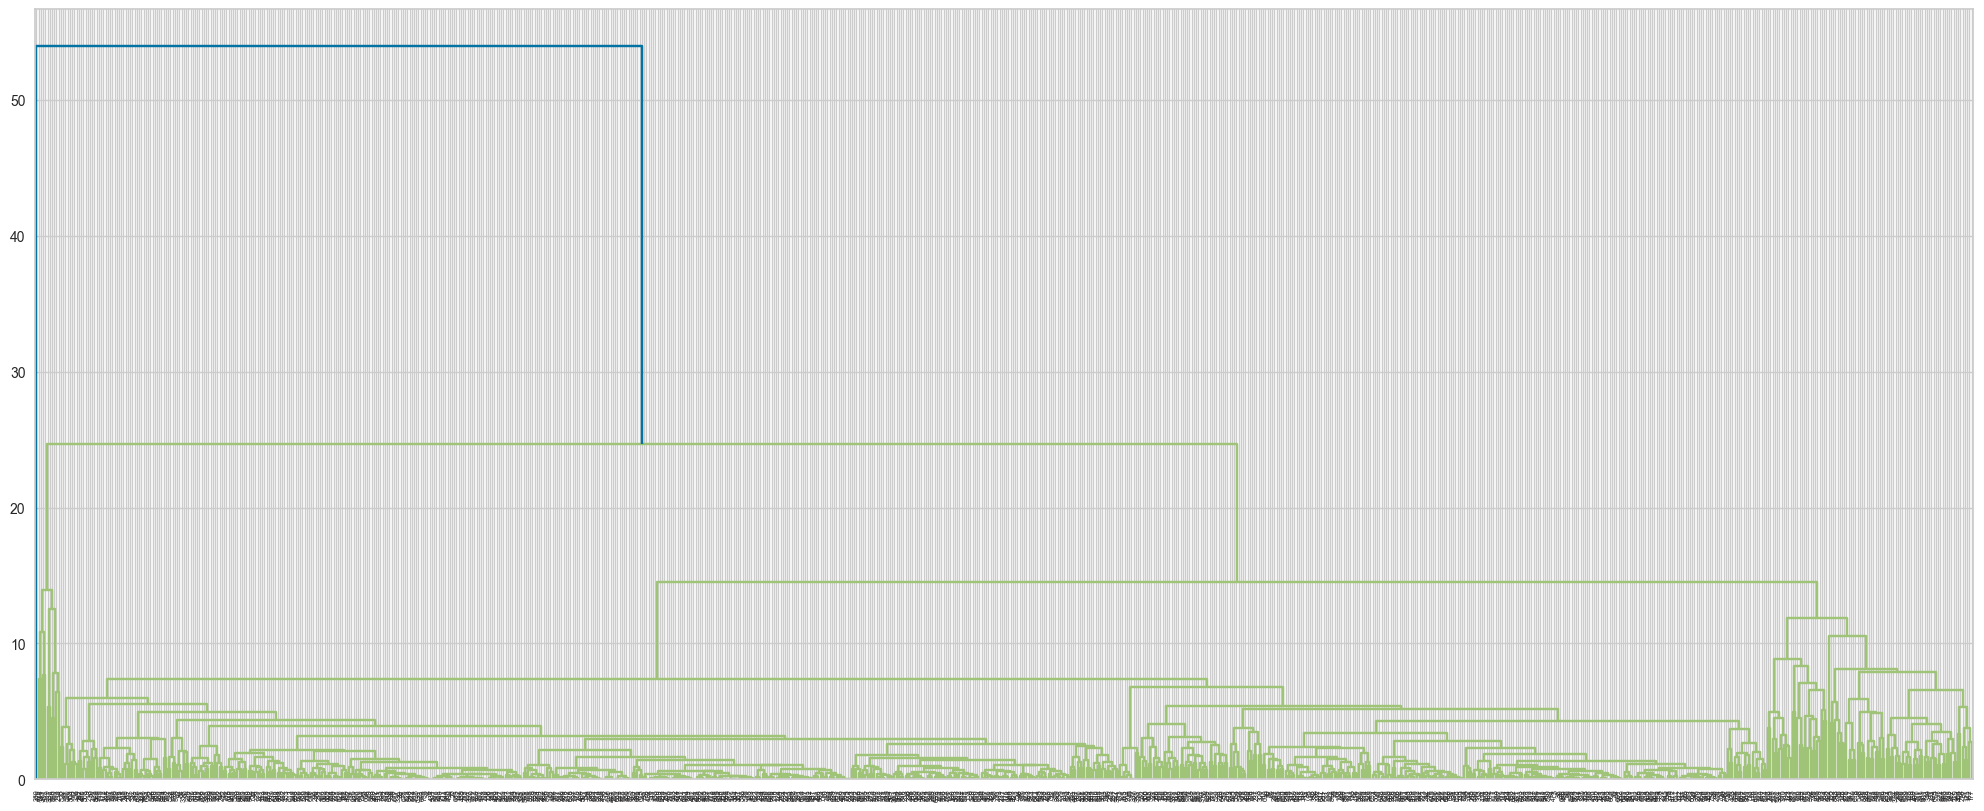

In [228]:
dota_den = linkage(dota_df2, 'complete', 'euclidean')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(dota_den)


To evaluate the quality of the clustering, we will rely on the 'cophenetic coefficient' which is a measure of how well the clustering preserves the pairwise distances in the original data. This is the same definition of the agglomerative coefficient (AC) used by the agnes library in R.

First we look at the results using the 'complete' method.

Then, we compare all available methods after that.

In [229]:
ac, ac_dist = cophenet(dota_den, pdist(dota_df2))
ac 

0.8653688104881122

In [230]:
m = {"average": "average", "single":"single", "complete":"complete", "ward":"ward"}
ac = {}

for key,value in m.items():
    ac, ac_dist = cophenet(linkage(dota_df2, method = value, metric = 'euclidean'), pdist(dota_df2))
    print("The AC score for the {0} method is {1:.2f}.".format(value, ac))

The AC score for the average method is 0.96.
The AC score for the single method is 0.92.
The AC score for the complete method is 0.87.
The AC score for the ward method is 0.75.


Keep in mind, the cophenetic coefficient ranges between 0 and 1 - with results betweenb 0.7 and 0.9 considered to be good and above 0.9 to be excellent.

In the real world, you'd evaluate your clustering based on the use case and in conjunction with other measures.

For our present purposes, the 'average' method appears to be best. Let's plot the dendrogram again using it.

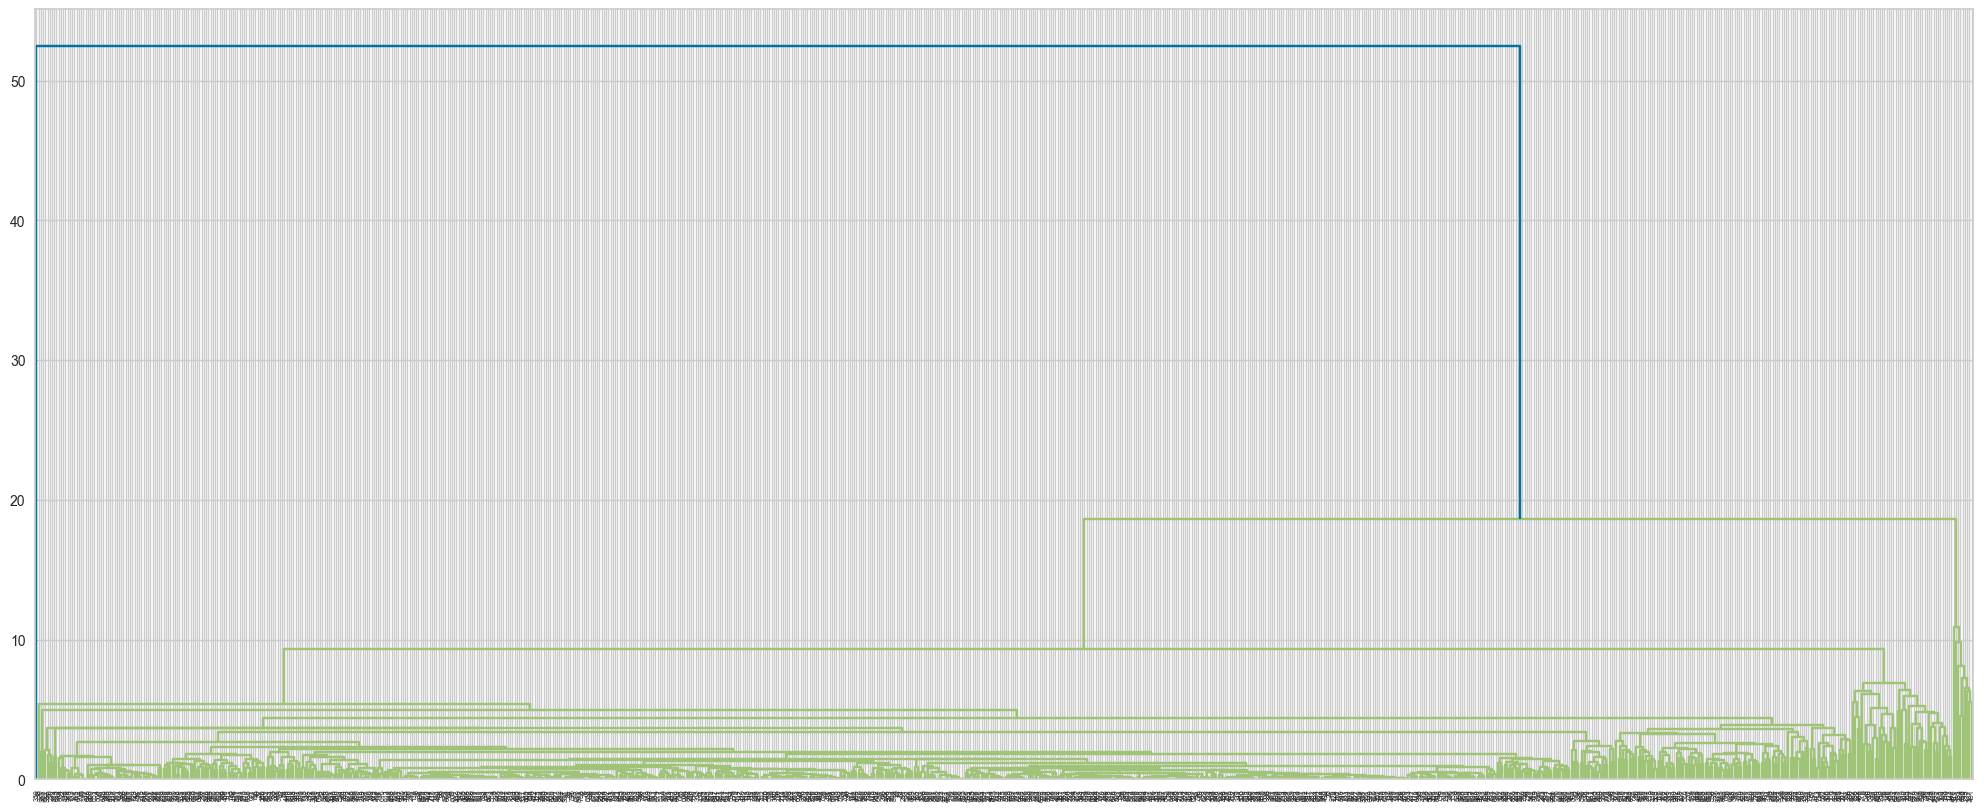

In [96]:
dota_den = linkage(dota_df2, 'average', 'euclidean')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(dota_den)

## Step 3: Cut the tree to obtain clustering

## Elbow Method

The Elbow method has a serious flaw in the order of the distance versus the order of clustering; basically, it compares distance jumps regardless of the order of the clustering. Also, it cannot ever indicate that the optimal cluster is 1 which is not very helpful. So, getting an answer of 2 being the optimal cluster might hide the fact that it really wants to suggest 1!

The scipy implementation of the Elbow plot even plots a second line showing you the strength of the elbow. Let's see that now.

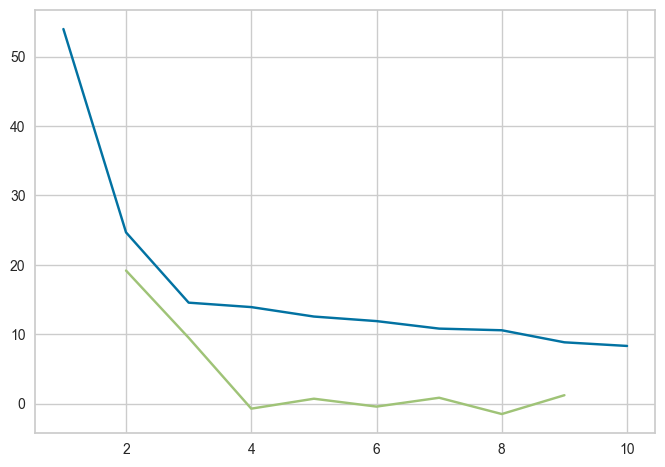

clusters: 2


In [276]:
last = dota_den[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

Here we see the "cluster: 2" recommendation. Per the comments above, this might not be what we really want. Moving along the green line, we see the "strength" drop as we near 4 clusters and then pop back up at 5 and 7. These are more realistic.

However, also per the weaknesses noted above, let's try to visualize this with the dendrogram.

## Manual Method, with dendrogram

Let's take a moment to look at the data generated by the linkage function above - this will give us a numerical representation of all those lines in the dendrogram above and helps us interpret what we see.

First, we'll place the array into a dataframe so it does print out with all scientific notation! This is important since the format of our output will be:

[[index1, index2, distance, count of samples]]. Index 517 will appear as 5.17000000e+02 in the numpy array. Not very interpretable!

In [275]:
dota_fmt = pd.DataFrame(dota_den)
dota_fmt = dota_fmt.rename(columns = {0 :'Index 1', 1 : 'Index 2', 2 : 'Distance', 3 : 'Num Samples'})
dota_fmt = dota_fmt[:10].style.format({'Index 1' : '{:,.0f}'.format, 'Index 2' : '{:,.0f}'.format, 'Distances' : '{:,.6f}'.format, 'Num Samples' : '{:,.0f}'.format})
dota_fmt

,Index 1,Index 2,Distance,Num Samples
0,517,518,0.002379,2
1,98,99,0.004239,2
2,29,815,0.004624,2
3,58,795,0.007320,2
4,255,682,0.008388,2
5,845,869,0.008561,3
6,137,139,0.008828,2
7,151,303,0.010347,2
8,163,831,0.010492,2
9,72,536,0.010956,2


So, in the first iteration, the algorithm clusters indices #517 and #518 with a distance of 0.002379 and tells us it clustered 2 samples. This is logical - it is agglomerative, so it starts with single observations and begins to create new "observations" out of them. 

So, at first, each observation is it's own cluster. Once it clusters its first two samples together, we have a new "observation" to place on the dendrogram. All original observations are at the bottom of the dendrogram because the vertical height (y axis) represents distance between points and the distance between a point and itself is clearly zero!

Gradually, the distances will increase - as will the point at which the dendrogram represents them being clusters along the y axis. These are the horizontal lines in the graph.

Also, take a look at the 6th iteration (row 5). How did it cluster index 845 with index 869? There are only 867 rows! This goes back to the new "observation" comment above. Index 869 represents a cluster formed by the algorithm. In reality, it clustered the sample at index 845 with the cluster at row 2 (indices 29 and 815) - hence it also tells us the new cluster contains 3 samples: 845, 29, and 815.

We know index 869 represents index 2 because 869-867 = 2!

Knowing this, let's add a little detail to our dendrogram and work toward choosing clusters by using it with the 'max_dist' parameter.

In [277]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata


Now, we will tweak two parameters to test a few of the clusters between 4 and 7. 

To do so, we'll tweak "p" for truncate_mode and max_d for a solid line representing the max distance. Wherever that line intersects a vertical line on the dendrogram, we tally 1 cluster.

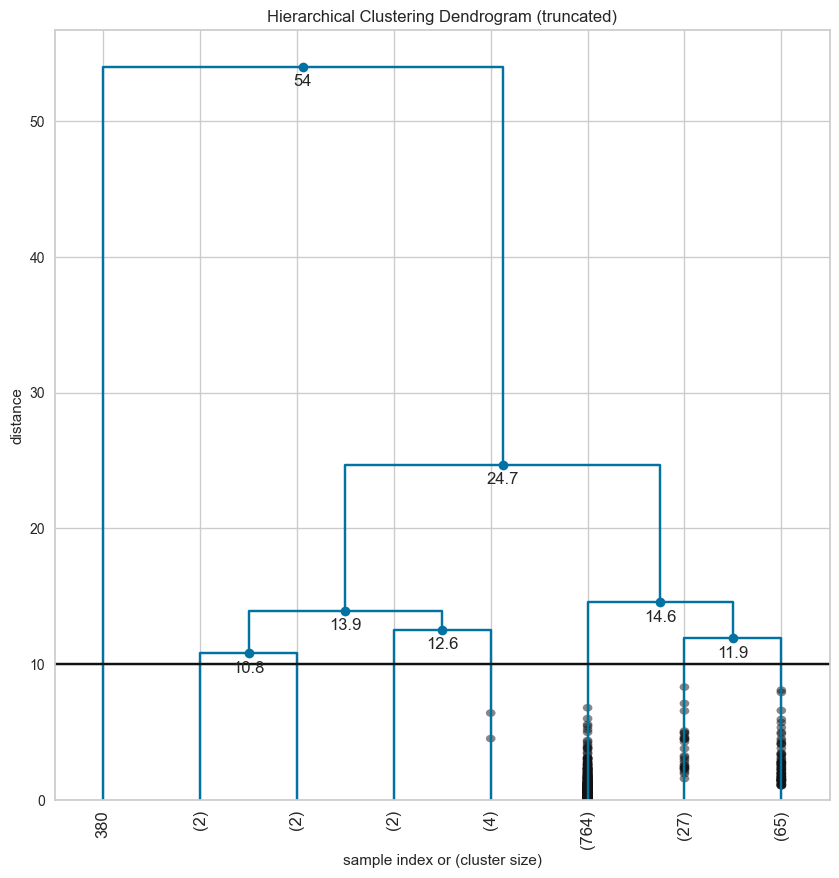

In [300]:
plt.figure(figsize=(10,10))
fancy_dendrogram(
    dota_den,
    truncate_mode='lastp',
    p=8,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,
    max_d=10,
)
plt.show()


By graphing the last eight merges we can see a max distance of ten gives us seven clusters. However, the x-axis values in parentheses are counts of samples and without are specific index numbers. So, in this case we have a single points left and six branches that clustered points below our current truncation. 

Does this make sense? Without knowing the underlying data well, it might be hard to say. Index 380 could be some sort of outlier and the seven clusters we see are indeed valid.

Quick note: The collection of "dots" on the branches represent the distances at which the unseen clusters were clustered below our truncation. Always inspect these for huge gaps because that means that there might be very distance data being put together that should not be together. Right now, everything looks acceptable.

Let's try six merges next. Keep an eye on where we have to put the max_dist parameter and how the number of samples in the clusters changes. Having two samples in a cluster is not much different than having a single observation.

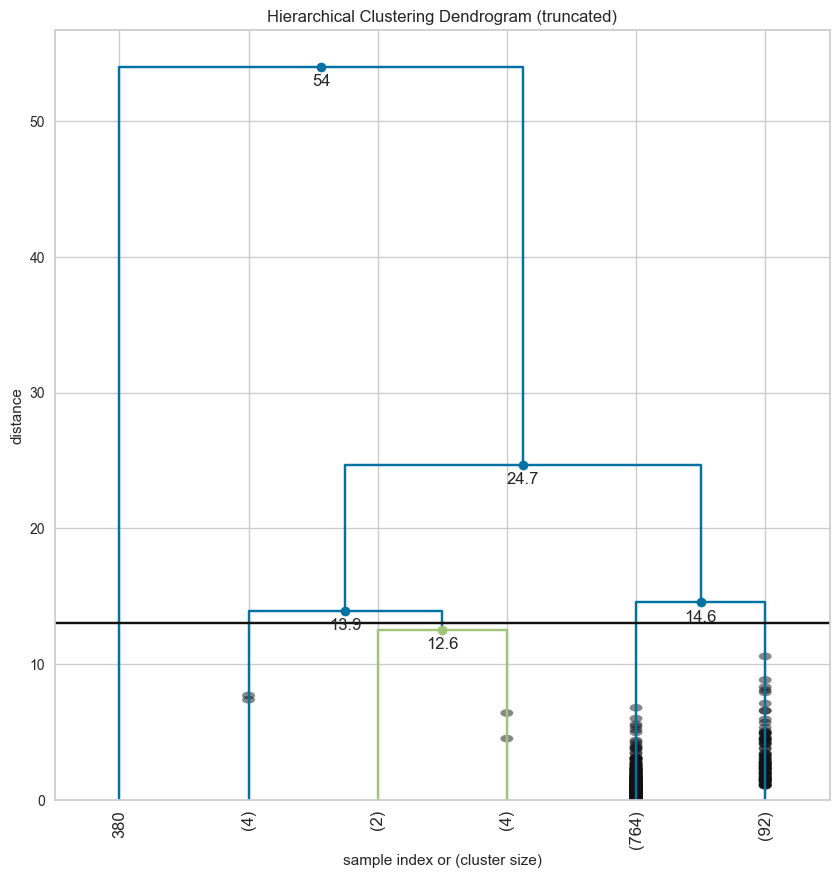

In [301]:
plt.figure(figsize=(10,10))
fancy_dendrogram(
    dota_den,
    truncate_mode='lastp',
    p=6,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,
    max_d=13,
)
plt.show()

We moved the max_dist to 13 in order to avoid the new cluster. It also gives us exactly five clusters.

At this point, let's also look again at the x-axis. The middle group comprised of three clusters with 4, 2, and 4 samples respectively, has not changed. The far right has lost one cluster and decreased to two. The previous branches with 27 and 65 sample become one.

Let's try one more time, choosing five merges.

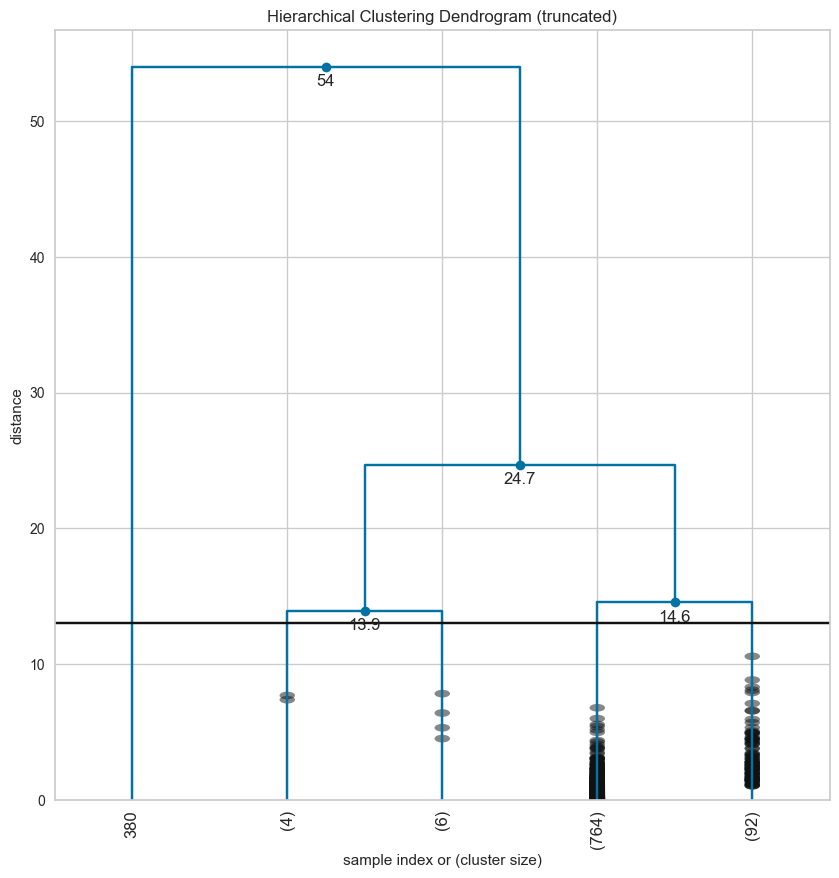

In [302]:
plt.figure(figsize=(10,10))
fancy_dendrogram(
    dota_den,
    truncate_mode='lastp',
    p=5,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,
    max_d=13,
)
plt.show()

Now, the middle cluster has decreased by one cluster - the clusters with 2 and 4 samples became one cluster with 6 samples.

The point of all this is that you have to make a judgement call - based on things like domain knowledge and/or knowledge of the underlying data - to decide whether dropping from seven to four clusters was worth it. At four clusters, things seems a bit skewed to one very large cluster, one medium-size cluster and two tiny clusters. What does that really tell you?

For that matter, are the seven we originally graphed informative? In all, if it does not make sense to cluster the players into numerous groups, the data might not hold the info you hope it does.

Lastly, always keep an eye on the distance spanned to cluster two groups or points together. The final cluster covers a distance measure of 54. So, the algorithm is taking all of the other points and clustering it with the single index remaining - 380. There is probably no meaningful reason to find similarity there. Even the second-to-last, with a distance of 24.7 is questionable.

This again leds to the conclusion that the least number of clusters is four.

## Step 4: Visualize the result

Using our max_d from above (which should give us 5 clusters) and another scipy function called fcluster, we can retrieve the cluster labels.

In [304]:
max_d = 13
clusters = fcluster(dota_den, max_d, criterion='distance')
clusters

array([4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 4, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3,
       3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 2, 4, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3,
       3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3,
       3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

Let's look at the counts of these clusters below. Look familiar?

In [305]:
cnt_labels = pd.DataFrame(clusters)
cnt_labels[0].value_counts()

3    764
4     92
2      6
1      4
5      1
Name: 0, dtype: int64

We can also try this by setting k = 5 with the same outcome.

In [306]:
k = 5 
clustersK = fcluster(dota_den, k, criterion='maxclust')
clustersK

array([4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 4, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3,
       3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 2, 4, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3,
       3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3,
       3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [308]:
cnt_labels_k = pd.DataFrame(clustersK)
cnt_labels_k[0].value_counts()

3    764
4     92
2      6
1      4
5      1
Name: 0, dtype: int64

In [311]:
pc_model = PCA(n_components=2)
dota_pc = pc_model.fit_transform(dota_df2)

In [313]:
dota_skill_level = np.append(dota_pc, dota_level, axis=1)
dota_skill_level

array([[5.414398226786892, -0.47554482642821566, 'B'],
       [-0.61525576014142, -0.07328373097234814, 'B'],
       [-1.5143653519235698, -0.1216768055987867, 'N'],
       ...,
       [-1.6218135800694273, -0.9829117054383796, 'N'],
       [0.988907386382027, 3.1047546208652657, 'B'],
       [-1.277905626101923, 2.102533106995696, 'N']], dtype=object)

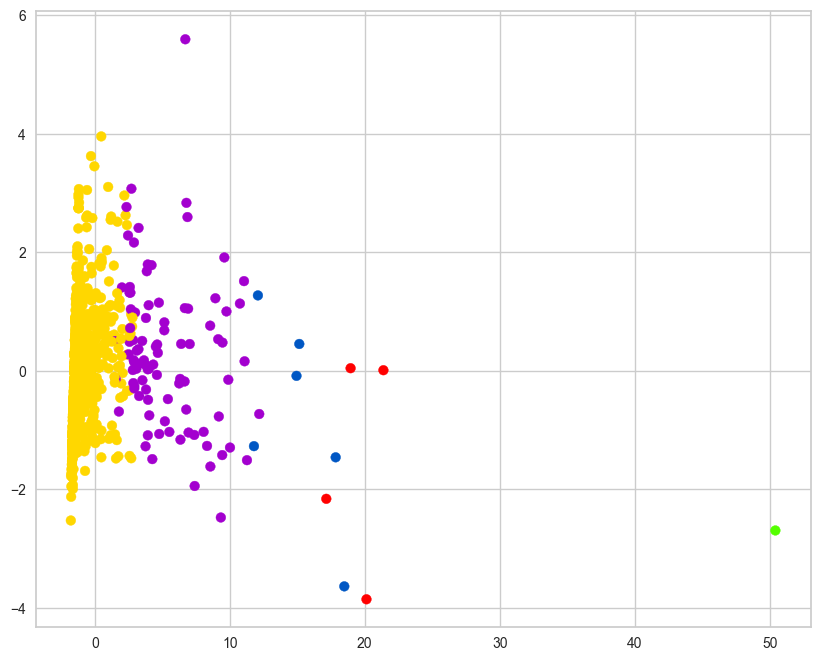

In [320]:
plt.figure(figsize=(10, 8))
plt.scatter(dota_pc[:,0], dota_pc[:,1], c=clusters, cmap='prism')
plt.show()

When we compare this plot to the plots in the previous labs, we should be pleasantly surprised that we have the same overall shape of all the points, but this time we have a little better differentiation. The 5 clusters, by color, stand out more from one another. And - despite some still questionable clustering due to apparent overlaps - each cluster tends to have its own "space".

One more observation: It seems as if there does seem to be some sort of logic at work here, though it might not be useful nonetheless. The clusters move from left to right, largest to smallest respectively. Perhaps there is some telling structure here.

Let's add the skill levels as styles.

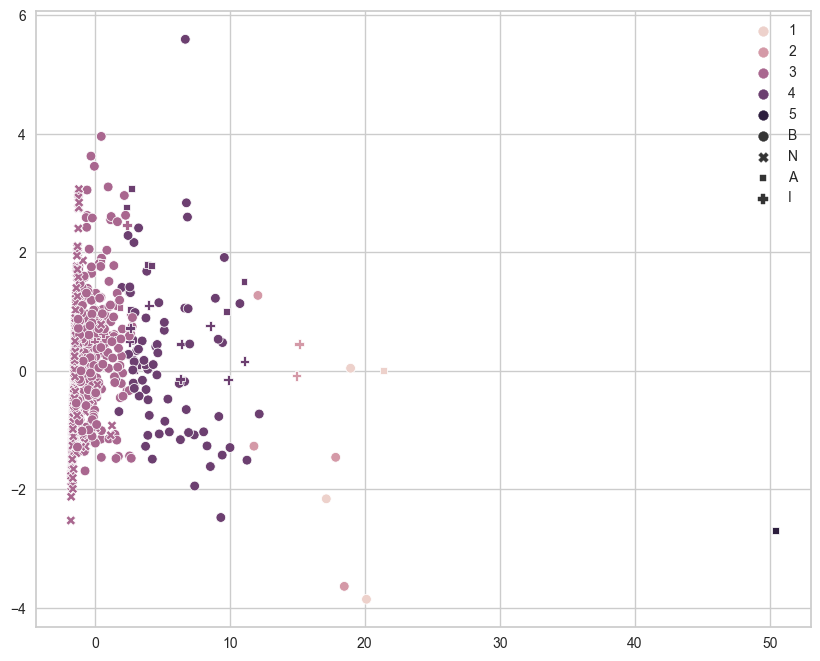

In [321]:
plt.figure(figsize=(10, 8))
sns.scatterplot(dota_pc, x=dota_skill_level[:,0], y=dota_skill_level[:,1], hue=clusters, style=dota_skill_level[:,2])
plt.show()

We seem to have come back to where we were in the other labs - the SkillLevels seem very scattered and overlapping. Again, more investigation is needed.